# VRPTW with mandatory rest, hererogeneous fleet and site dependence

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from docplex.mp.model import Model
from docplex.mp.conflict_refiner import ConflictRefiner
import networkx as nx
import time

## Data

In [2]:
data_name = '20191020_1536'
num_instances = 25
solomon_instance = 'c201'

In [ ]:
%run read_data_rand_solomon.py $num_instances $solomon_instance $data_name

In [6]:
G = nx.from_pandas_edgelist(arcs, 
                              'start', 'end', ['Distancia (km)','Tempo (h)'], create_using=nx.DiGraph)

## Optimization model

In [10]:
mdl = Model('VRPTW2')

Decision variables

In [11]:
x_keys = [(i, j, k) for k in fleet_list
                    for (i,j) in arcs[arcs['Veiculo']==fleet_df.loc[k]['Veiculos']][['start', 'end']].itertuples(index=False)]
z_keys = [(i, k) for i in start_nodes_list for k in fleet_list]
x = mdl.binary_var_dict(x_keys, name='x')
y = mdl.binary_var_list(fleet_list, name='y')
z = mdl.binary_var_dict(z_keys, name='z')
Ns = mdl.integer_var_dict(z_keys, name='Ns', lb=0, ub=horizon)
Ws = mdl.continuous_var_dict(z_keys, name='ws', lb=0, ub=day-eps)
Nt = mdl.integer_var_dict(x_keys, name='Nt', lb=0, ub=horizon)
Wt = mdl.continuous_var_dict(x_keys, name='wt', lb=0, ub=work_shift-eps)
s = mdl.continuous_var_matrix(start_nodes_list, fleet_list, name='s', lb=0)

Objective function

In [12]:
start_time = time.perf_counter()

In [13]:
mdl.minimize(mdl.sum(get_dist(i, j, k) * x[(i, j, k)] * freightCost_list[k] for (i, j, k) in x_keys) + 
             mdl.sum(y[k] * fixedCost_list[k] for k in fleet_list))

In [14]:
mdl.add_constraints((mdl.sum(x[0, j, k] for j in customers_list if (0, j, k) in x_keys)== y[k] for k in fleet_list), 
                    names=['vehicle_{}_usage'.format(k) for k in fleet_list])
mdl.add_constraints([mdl.sum(x[i, j, k] for k in fleet_list for j in nodes_list if j!=0 and j!=i and (i, j, k) in x_keys)==1 for i in customers_list],
                    names=['visit_customer_{}'.format(i) for i in customers_list])
mdl.add_constraints([mdl.sum(demand_volume[i] * 
                             mdl.sum(x[i, j, k] for j in end_nodes_list if j!=i and (i, j, k) in x_keys) 
                             for i in customers_list) <= QVolume_list[k] * y[k] for k in fleet_list],
                    names=['volume_capacity_{}'.format(k) for k in fleet_list])
mdl.add_constraints([mdl.sum(demand_value[i] * 
                            mdl.sum(x[i, j, k] for j in end_nodes_list if j!=i and (i, j, k) in x_keys) 
                             for i in customers_list) <= QValue_list[k] * y[k] for k in fleet_list],
                    names=['value_capacity_{}'.format(k) for k in fleet_list])
mdl.add_constraints([mdl.sum(x[0, j, k] for j in end_nodes_list  if (0, j, k) in x_keys)==1 for k in fleet_list], 
                     names=['start_from_CD_{}'.format(k) for k in fleet_list])
mdl.add_constraints([mdl.sum(x[i, h, k] for i in start_nodes_list if i!=h and (i, h, k) in x_keys) == 
                     mdl.sum(x[h, j, k] for j in end_nodes_list if j!=h and (h, j, k) in x_keys) for h in customers_list 
                     for k in fleet_list],
                    names=['flow_constraint_{}_{}'.format(h, k) for h in customers_list for k in fleet_list])
mdl.add_constraints([mdl.sum(x[i, n+1, k] for i in start_nodes_list if (i, n+1, k) in x_keys)==1 for k in fleet_list],
                    names=['end_in_CD_{}'.format(k) for k in fleet_list])
mdl.add_constraints([start_windows[i] <= s[i, k] for i in customers_list for k in fleet_list],
                    names=['left_window_{}_{}'.format(i, k) for i in customers_list for k in fleet_list])
mdl.add_constraints([s[i, k] <= end_windows[i] for i in customers_list for k in fleet_list],
                    names=['right_window_{}_{}'.format(i, k) for i in customers_list for k in fleet_list])
mdl.add_constraints([s[0, k] == vehicle_start_hour[k] for k in fleet_list],
                    names=['start_time_from_CD_{}'.format(k) for k in fleet_list])
mdl.add_constraints([s[i, k] + get_time(i, j, k) + service_time[i] <= s[j, k] + (1 - x[i, j, k])*get_M(i, j, k) 
                     for i in start_nodes_list for j in customers_list for k in fleet_list if i!=j and (i, j, k) in x_keys],
                    names=['service_continuity_{}_{}_{}'.format(i, j, k) for i in start_nodes_list for j in customers_list 
                           for k in fleet_list if i!=j and (i, j, k) in x_keys])
mdl.add_constraints([(s[i, k] + service_time[i] - vehicle_start_hour[k]) == ((Ns[i, k]*day) + Ws[i, k]) for i in start_nodes_list 
                     for j in end_nodes_list for k in fleet_list if i!=j and (i, j, k) in x_keys], 
                     names=['working_hours_{}_{}'.format(i, k) for i in start_nodes_list for j in end_nodes_list 
                            for k in fleet_list if i!=j and (i, j, k) in x_keys])
mdl.add_indicator_constraints([mdl.indicator_constraint(x[i, j, k], Ws[i, k] + get_time(i, j, k) - work_shift + eps <= Mp * (1 - z[i, k]), 
                                                       active_value=1, name='need_rest_after_{}_{}_{}'.format(i, j, k))
                              for i in start_nodes_list for j in customers_list for k in fleet_list if i!=j and (i, j, k) in x_keys])
mdl.add_indicator_constraints([mdl.indicator_constraint(x[i, j, k], Ws[i, k] + get_time(i, j, k) == Nt[i, j, k] * work_shift + Wt[i, j, k], 
                                                       active_value=1, name='rest_time_{}_{}_{}'.format(i, j, k))
                              for i in start_nodes_list for j in customers_list for k in fleet_list if i!=j and (i, j, k) in x_keys])
mdl.add_indicator_constraints([mdl.indicator_constraint(x[i, j, k], ((s[i, k] + service_time[i] + get_time(i, j, k) + Nt[i, j, k] * rest_shift) - s[j, k]) <= Mp * z[i, k],
                                                       active_value=1, name='serve_after_rest_{}_{}_{}'.format(i, j, k))
                              for i in start_nodes_list for j in customers_list for k in fleet_list if i!=j and (i, j, k) in x_keys])
print("Added constraints")

Added constraints


In [15]:
end_time = time.perf_counter()
obj_cst_time = end_time - start_time
print(obj_cst_time)

791.5650526000001


In [16]:
# both limited to 1000 in trial version
print("Number of constraints: " + str(mdl.number_of_constraints)) 
print("Number of variables: " + str(mdl.number_of_variables))

Number of constraints: 174553
Number of variables: 111132


In [ ]:
solution = mdl.solve(log_output=True)
print(mdl.solve_details)
print(solution.solve_status)

In [24]:
active_vehicles = [i for i in fleet_list if y[i].solution_value>0]
active_arcs = [(i, j, k) for (i, j, k) in x_keys if x[i, j, k].solution_value>0]
routes = {v:[(i, j) for i, j, k in active_arcs if k==v] for v in active_vehicles}
svc_times = {k:{i: s[i, k].solution_value for i, j in routes[k] if i in nodes_list} for k in active_vehicles}

In [25]:
print("Objective value: " + str(solution.objective_value))
print("Service times: " + str(svc_times))
print("Active vehicles: " + str(active_vehicles))
# vehicles
print("Vehicle types: " + str([fleet_df['Veiculos'].iloc[k] for k in active_vehicles]))
print("Routes: " + str(routes))

Objective value: 26297.7051776577
Service times: {1: {0: 7.0, 2: 59.99999999999999}, 16: {0: 7.0, 3: 73.0}, 17: {0: 8.0, 5: 59.999999999999986}, 18: {11: 35.0, 0: 6.0, 10: 54.0}, 20: {0: 8.0, 4: 37.0}, 22: {24: 10.475000000000023, 0: 7.0, 6: 13.0}, 24: {0: 6.0, 1: 21.999999999999996, 7: 37.0}, 27: {0: 6.0, 8: 72.0}, 30: {13: 35.0, 0: 6.0, 9: 57.0}, 31: {0: 7.0, 14: 56.0, 25: 60.82499999999999}, 39: {0: 6.0, 16: 35.0, 19: 36.46721680981652}, 42: {0: 6.0, 17: 12.01789277477549, 23: 63.00000000000001}, 45: {0: 6.0, 15: 36.00000000000001, 18: 37.88388347648319}, 46: {0: 7.0, 22: 18.0}, 47: {21: 31.0, 0: 8.0, 20: 47.0}, 51: {0: 6.0, 12: 48.0}}
Active vehicles: [1, 16, 17, 18, 20, 22, 24, 27, 30, 31, 39, 42, 45, 46, 47, 51]
Vehicle types: ['veiculo1', 'veiculo2', 'veiculo2', 'veiculo2', 'veiculo2', 'veiculo2', 'veiculo2', 'veiculo2', 'veiculo3', 'veiculo3', 'veiculo3', 'veiculo3', 'veiculo3', 'veiculo3', 'veiculo3', 'veiculo3']
Routes: {1: [(0, 2), (2, 26)], 16: [(0, 3), (3, 26)], 17: [(0, 5

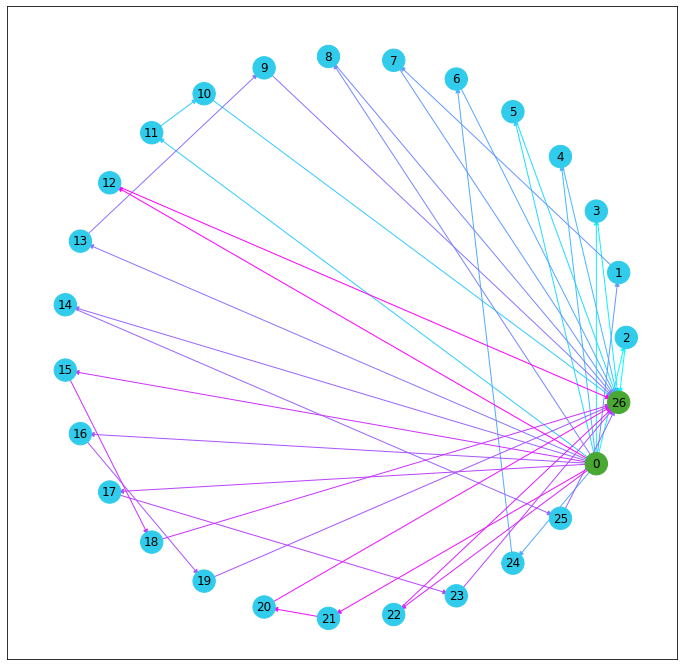

In [26]:
plt.figure(figsize=(12, 12))
values = ['#31cceb' if node!=0 and node!=n+1 else '#48a832' for node in G.nodes]
#pos = nx.kamada_kawai_layout(G, pos=nx.get_node_attributes(G,'pos'), center=(0, 0)) #weight='distance'
#pos = nx.spring_layout(G, k=50, pos=nx.get_node_attributes(G,'pos'), weight='distance')
pos = nx.circular_layout(G, scale=1, center=(0,0))
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                       node_color = values, node_size = 500)
nx.draw_networkx_labels(G, pos)
color_idx = np.linspace(0, 1, len(routes.items()))
for i, (vehicle, edges) in enumerate(routes.items()):
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=matplotlib.colors.to_hex(plt.cm.cool(color_idx[i])), arrows=True)
    edge_distances = nx.get_edge_attributes(G, 'Distancia (km)')
    edge_distances_to_draw = {e:edge_distances[e] for e in edges}
    #nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_distances_to_draw)
#plt.show()
plt.savefig(os.path.join(dir_path, "comparisons", "routes","figures",'cplex_routes_'+data_name+'_'+str(num_instances)+'_'+solomon_instance+'.png'))